# GaugePredict Data Downloader

This is a tool to download discharge data 

#### Download Packages

In [6]:
import os
import sys
import json
from pathlib import Path
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import cmocean 
import contextily as ctx
from dataretrieval import nwis
import warnings
warnings.filterwarnings("ignore")

Upload shape files:
Water boundaries USGS: https://www.sciencebase.gov/catalog/item/61fd7d49d34e622189cf3aab

(2700000.0, 6520000.0)

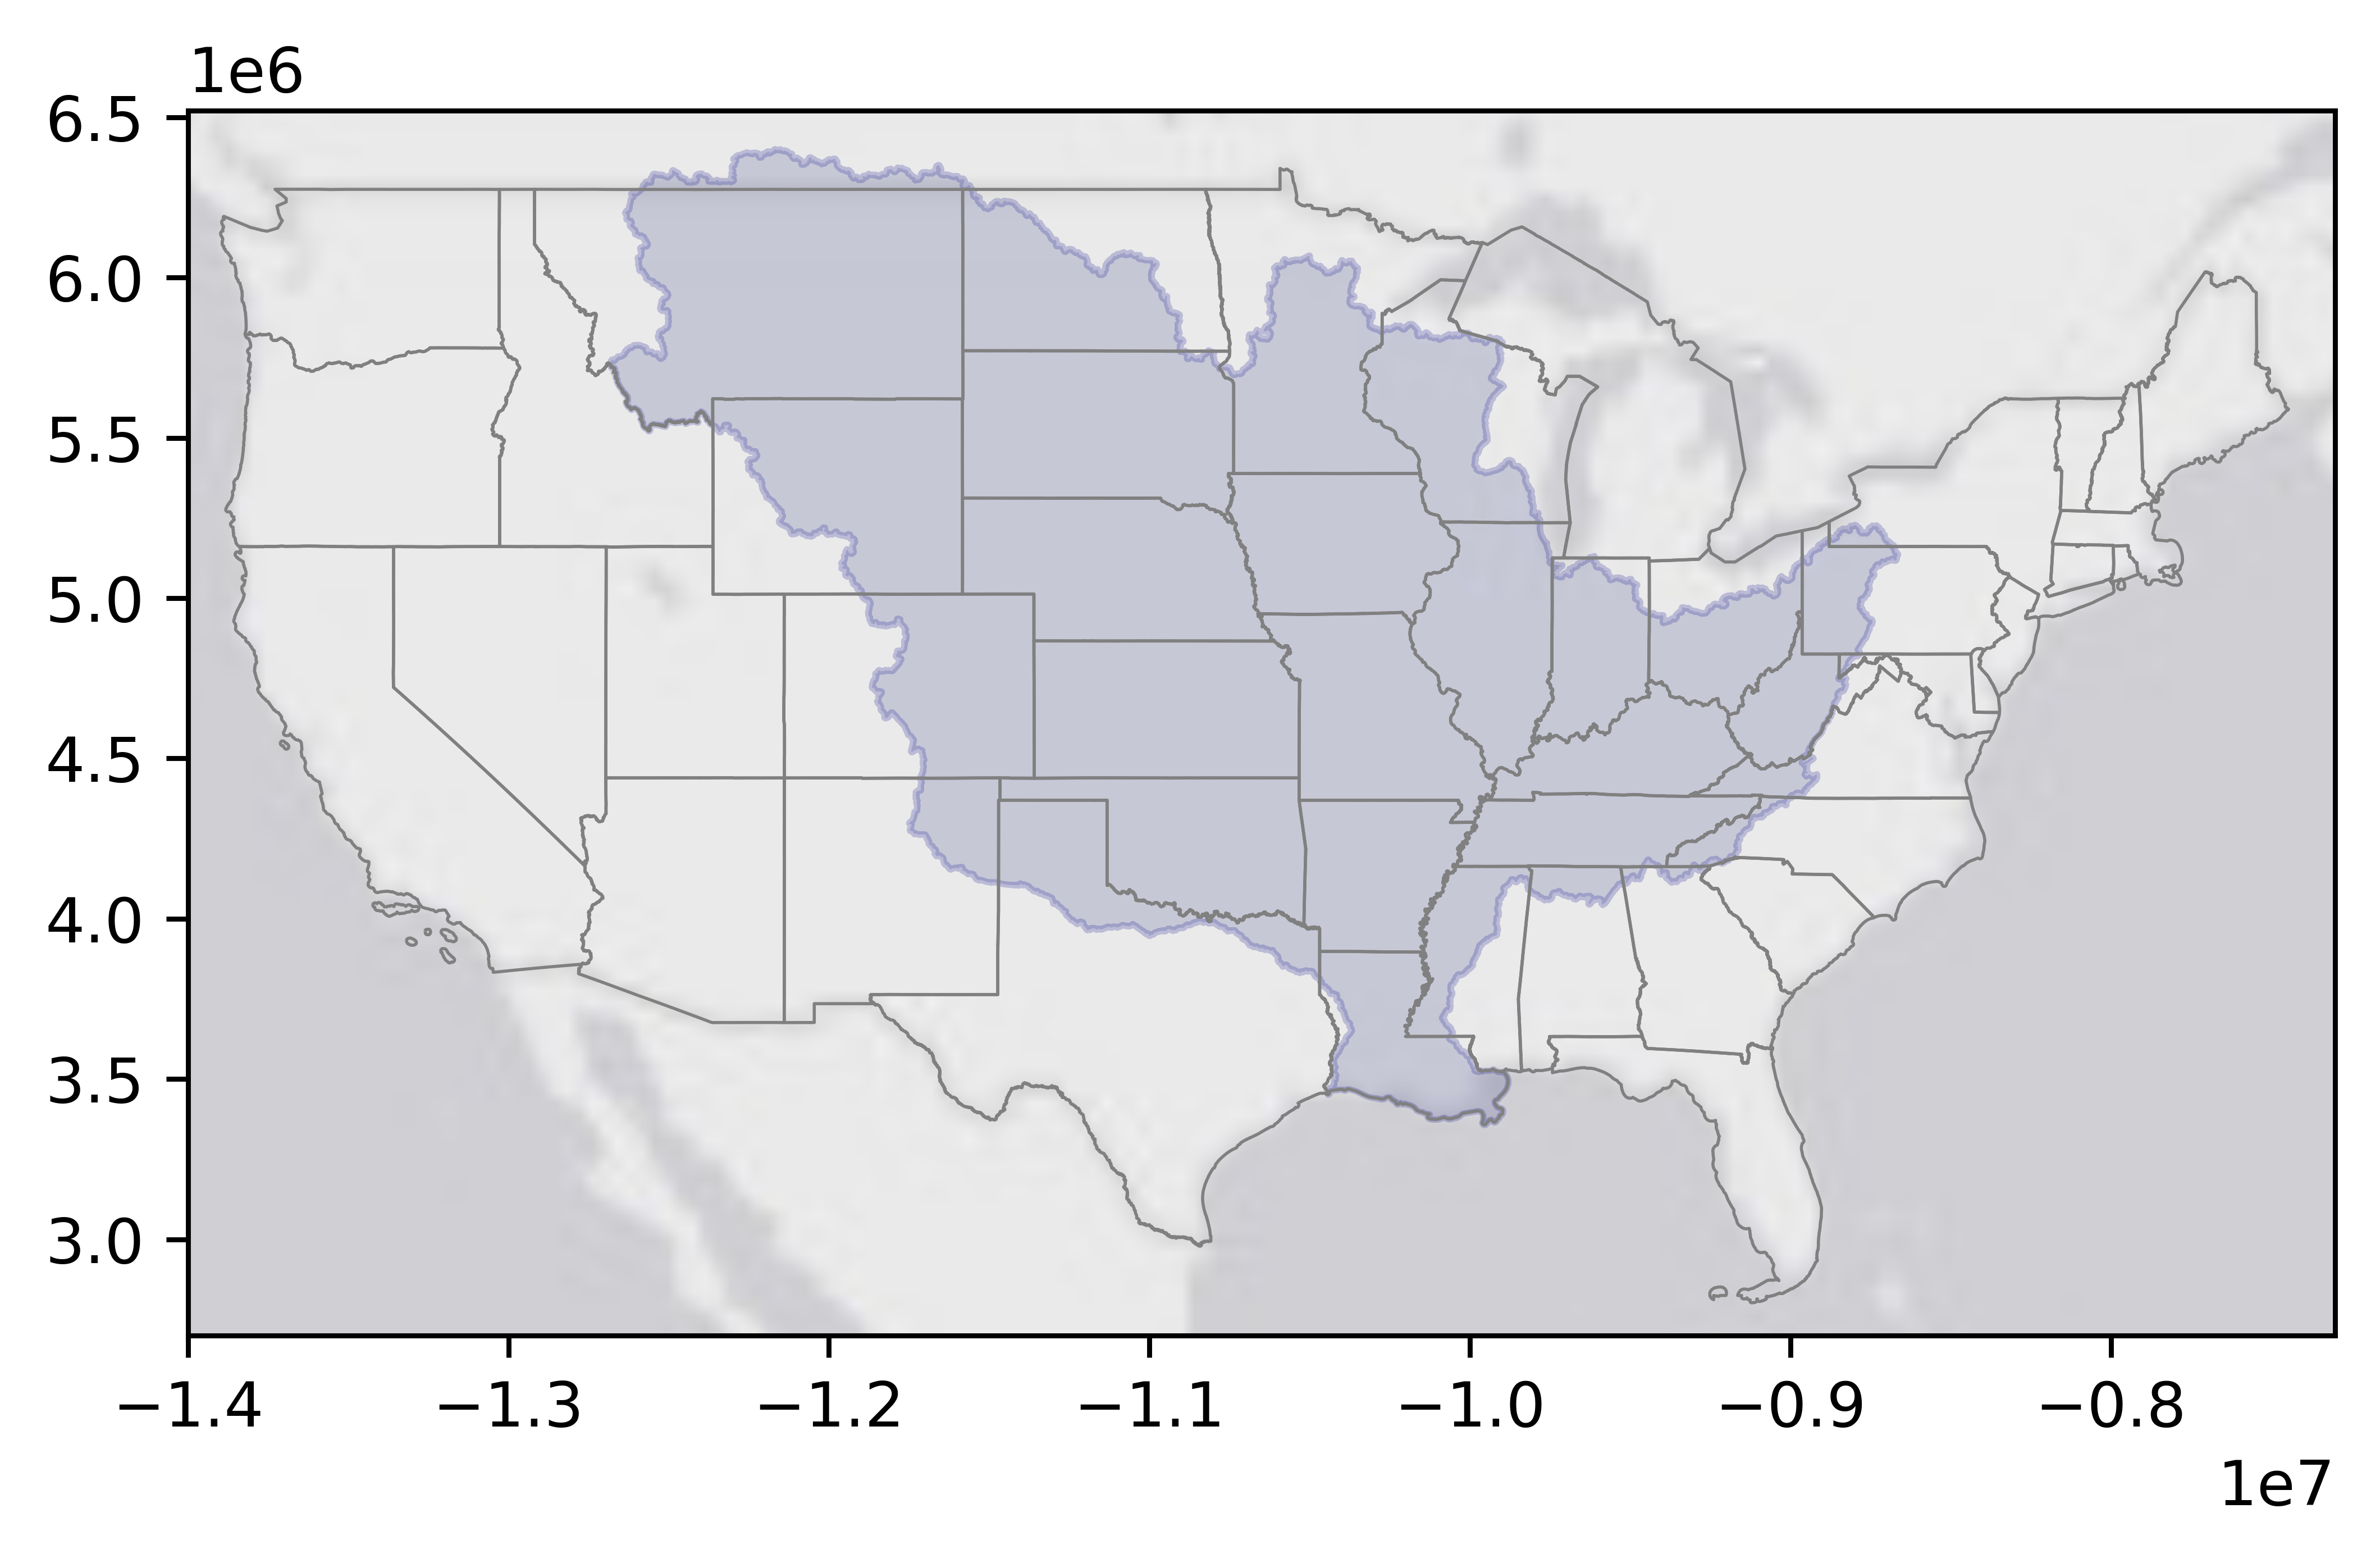

In [7]:
basin_fp = "shapefiles/MSRB/Miss_RiverBasin.shp"
states_fp = "shapefiles/US_STATES/tl_2023_us_state.shp"
basin = gpd.read_file(basin_fp).to_crs(epsg=3857)
states = gpd.read_file(states_fp).to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(7.33, 3.54), dpi = 800)
basin.plot(ax=ax,facecolor=cmocean.cm.ice(0.3), edgecolor='darkblue', alpha=0.2)
states.boundary.plot(ax=ax, linewidth=0.5, edgecolor='gray')
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldGrayCanvas, attribution=False, zoom = 2)
ax.set_xlim(-14000000, -7300000) 
ax.set_ylim(2700000, 6520000)  

In [8]:
data_dir = Path("cached_data_parameter")
json_path = data_dir / "site_dict_parameter.json"
start_date, end_date = "2005-01-02", "2024-12-31"
huc_codes = ["02", "03", "04","05", "06", "07", "08", "09", "10", "11", "14"]
percent_threshold = 95 
paramter_code = "00060"
parameter = "discharge"
data_dir = Path(f"cached_data_{parameter}")


In [ ]:
full_index = pd.date_range(start=start_date, end=end_date)
data_dir.mkdir(exist_ok=True)
huc_codes = huc_codes
site_info_list = []

for huc_code in huc_codes:
    sites = nwis.what_sites(huc=huc_code, parameterCd=paramter_code)
    if isinstance(sites, tuple):
        sites = sites[0]
    sites['HUC'] = huc_code
    site_info_list.append(sites)

site_info_df = pd.concat(site_info_list, ignore_index=True)
site_info_df = site_info_df[['site_no', 'dec_lat_va', 'dec_long_va', 'HUC']].rename(
    columns={'dec_lat_va': 'Latitude', 'dec_long_va': 'Longitude'}
)

start_date = pd.to_datetime(start_date).tz_localize("UTC")
end_date = pd.to_datetime(end_date).tz_localize("UTC")  
expected_days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days

data_coverage = []
parameter_data = {}


for site_no in site_info_df['site_no']:
    try:
        df = nwis.get_dv(sites=site_no, parameterCd=paramter_code, start=start_date, end=end_date)[0]
        df['site_no'] = site_no
        valid_days = df[paramter_code].dropna().count()
        data_coverage.append({'site_no': site_no, 'valid_days': valid_days})
        parameter_data[site_no] = df

    except Exception as e:
        print(f"Skipping site {site_no}: {e}")

coverage_df = pd.DataFrame(data_coverage)
coverage_df['completeness_%'] = 100 * coverage_df['valid_days'] / expected_days
coverage_df = coverage_df.merge(site_info_df, on='site_no', how='left')
coverage_df = coverage_df.sort_values(by='completeness_%', ascending=False)

high_quality_sites = coverage_df[coverage_df['completeness_%'] > percent_threshold]
high_quality_ids = set(high_quality_sites['site_no'])

site_dict = {huc: {} for huc in huc_codes}

for site_no, df in parameter_data.items():
    if site_no not in high_quality_ids:
        continue

    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    df.index = df.index.tz_localize("UTC")
    parameter_col = [col for col in df.columns if paramter_code in col and 'Sum' in col]
    if not parameter_col:
        print(f"not found for site {site_no}. Skipping...")
        continue

    parameter_ts = df[parameter_col[0]].sort_index()


    row = high_quality_sites.loc[high_quality_sites['site_no'] == site_no]
    lat = row['Latitude'].values[0]
    lon = row['Longitude'].values[0]
    completeness = row['completeness_%'].values[0]
    huc = row['HUC'].values[0]

    site_dict[huc][site_no] = {
        'Latitude': lat,
        'Longitude': lon,
        'completeness_%': completeness,
        'parameter': parameter_ts,
        'cluster': None,
        'HUC': huc
    }

# Save to JSON
json_serializable_dict = {}

for huc_code, sites in site_dict.items():
    json_serializable_dict[huc_code] = {}
    for site_no, info in sites.items():
        parameter = info['parameter'].dropna()
        parameter_dict = {str(k): float(v) for k, v in parameter.items()}

        json_serializable_dict[huc_code][site_no] = {
            'Latitude': info['Latitude'],
            'Longitude': info['Longitude'],
            'completeness_%': info['completeness_%'],
            'parameter': parameter_dict,
            'cluster': info['cluster'],
            'HUC': huc_code
        }

with open(json_path, 'w') as f:
    json.dump(json_serializable_dict, f)